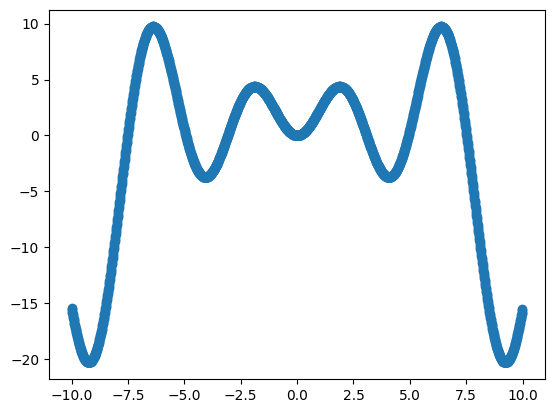

In [86]:
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt

# sin(𝑥)𝑥−𝑥10
def f_x (x: ndarray):
    return x*np.sin(0.5*x)+x*np.sin(1.1*x)+x*np.sin(1.3*x)

delta_x=0.01
x = list()
y = list()
for i in range(-1000,1000):
    xtr = i*delta_x
    x.append(xtr)
    y.append(f_x(xtr))
x=np.array(x)
y=np.array(y)

plt.plot(x,y)
plt.scatter(x,y)


[[-9.41573539 -9.31311528 -9.03886319 ...  9.42713819  9.48958842
   9.96976553]
 [-9.97807616 -9.6187904  -9.24760819 ...  8.41323476  9.06607308
   9.52344155]
 [-9.33603542 -9.1933637  -9.18969595 ...  8.62036463  9.40909218
   9.9663234 ]
 ...
 [-9.94732106 -9.66948327 -9.28849315 ...  9.24891157  9.34034806
   9.80994477]
 [-9.98851979 -9.95482033 -9.59883419 ...  8.43410574  8.52671278
   9.66547731]
 [-9.98881333 -9.8076614  -9.16711864 ...  9.36358605  9.93105777
   9.99834566]]


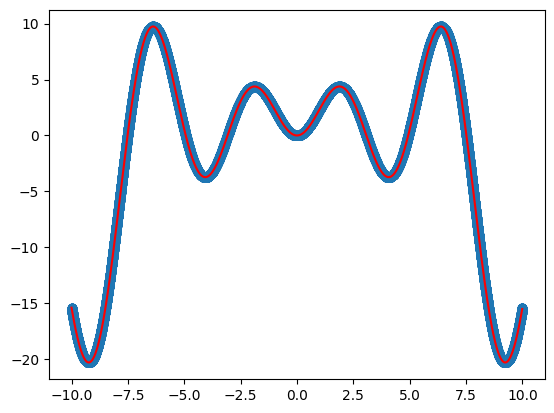

In [87]:


VECTOR_SIZE=64
VECTOR_NUM=500
    
X = np.random.uniform(-10,10,(VECTOR_NUM,VECTOR_SIZE))
X = np.sort(X,axis=1)
print(X)
Y = f_x (X)

plt.scatter(X,Y)
plt.plot(x,y,color='red')


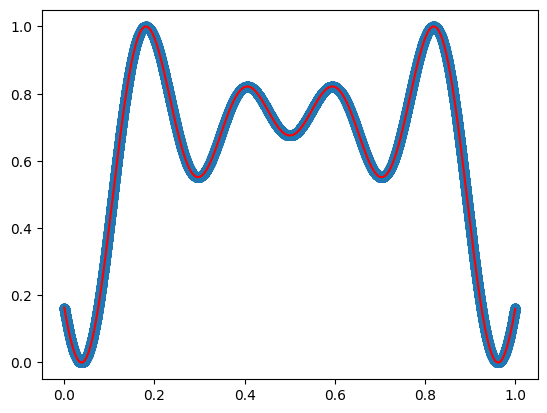

In [88]:
def rescale (array: ndarray):
    array = array-np.min(array)
    array = array/np.max(array)
    return array

x = rescale(x)
y = rescale(y)
X = rescale(X)
Y = rescale(Y)

plt.scatter(X,Y)
plt.plot(x,y,color='red')

In [89]:
GEN_SIZE=8

XG = np.random.uniform(0.0,1.0,(VECTOR_NUM,GEN_SIZE))
XG


array([[0.11022145, 0.58662775, 0.90304367, ..., 0.57776986, 0.62482267,
        0.59408686],
       [0.14939014, 0.70340758, 0.55387392, ..., 0.75596493, 0.58695492,
        0.67437577],
       [0.79270937, 0.92762662, 0.13610414, ..., 0.43932705, 0.56658991,
        0.53249567],
       ...,
       [0.12864581, 0.44853488, 0.70131937, ..., 0.83229898, 0.02101658,
        0.36208801],
       [0.19946008, 0.47067212, 0.15833427, ..., 0.15687121, 0.12295782,
        0.56237797],
       [0.38042082, 0.63859871, 0.4013233 , ..., 0.07979762, 0.19879866,
        0.83221582]])

In [90]:
import math
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F


class P2ScaleGenerator(nn.Module):

    def __init__(self, input_size, output_size, batch_norm_enabled=True):
        super(P2ScaleGenerator,self).__init__()
        
        # Making the basic perceptron:---------------------------------
        self.layers=[]
        dropout_base = 0.05
        layer_quantity = int(math.log2(output_size)-math.log2(input_size))
        
        for cnt in range(0,layer_quantity):
            coef = math.pow(2,cnt)
            input_vector_size=int(coef*input_size)
            node_number=int(2*coef*input_size)
            #print (input_vector_size,node_number)
            self.layers.append(nn.Linear(input_vector_size,node_number))
            if batch_norm_enabled == True:
                self.layers.append(nn.BatchNorm1d(node_number))

        # Registering modules for torch:-------------------------------
        for cnt,layer in enumerate(self.layers):
            self.add_module("layer{}".format(cnt),layer)

    def forward(self, xtr):
        for cnt,layer in enumerate(self.layers):
            #xtr = F.relu(layer(xtr))
            if cnt<len(self.layers)-1:
                xtr = F.tanh(layer(xtr))
            else :
                xtr = F.sigmoid(layer(xtr))
        return xtr


In [106]:

# This class was copied from the previous task-3:---------------------------------------

class Perceptron(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, hidden_layer_quantity, batch_norm_enabled=True):
        
        super().__init__()
        self.layers = []
        dropout_base = 0.05
        input_size = int(input_size)
        hidden_size = int(hidden_size)
        output_size = int(output_size)
        hidden_layer_quantity = int(hidden_layer_quantity)
        
        # Making the basic perceptron:---------------------------------
        self.layers.append(nn.Linear(input_size,hidden_size))
        self.layers.append(nn.Dropout( dropout_base ))
        
        for cnt in range(0,hidden_layer_quantity):
            self.layers.append(nn.Linear(hidden_size,hidden_size))
            if batch_norm_enabled == True:
                self.layers.append(nn.BatchNorm1d(hidden_size))
            drop_coef = (1.0/hidden_layer_quantity) * cnt + 2*dropout_base
            drop_coef = 0.80 if drop_coef>0.80 else drop_coef
            self.layers.append(nn.Dropout( drop_coef ))
        self.layers.append(nn.Linear(hidden_size,output_size))

        # Registering modules for torch:-------------------------------
        for cnt,layer in enumerate(self.layers):
            key = "layer{}".format(cnt)
            self.add_module(key,layer)

    def forward(self, xtr):
        for cnt,layer in enumerate(self.layers):
            if cnt<len(self.layers)-1:
                xtr = F.leaky_relu(layer(xtr))
            else :
                xtr = F.sigmoid(layer(xtr))
        return xtr


In [107]:
#pip install torchsummary

In [114]:
#from torchsummary import summary

generator = P2ScaleGenerator(input_size=GEN_SIZE, output_size=VECTOR_SIZE)
print (generator)

discriminator = Perceptron(input_size=VECTOR_SIZE, hidden_size=VECTOR_SIZE/2, output_size=1, hidden_layer_quantity=1)
print(discriminator)

gen_optimizer = torch.optim.SGD(generator.parameters(),lr=0.005,momentum=0.001)

# gen_optimizer = torch.optim.Adam(
#     generator.parameters(),
#     lr=0.00001#,
#     #betas=(0.3, 0.99)
# )

dis_optimizer = torch.optim.SGD(discriminator.parameters(),lr=0.0001,momentum=0.0001)

# dis_optimizer = torch.optim.Adam(
#     discriminator.parameters(),
#     lr=0.00001#,
#     #betas=(0.3, 0.99)
# )

loss_function = nn.MSELoss(reduction='sum')#torch.nn.BCELoss() #nn.MSELoss(reduction='sum') #torch.nn.BCELoss()
threshold=VECTOR_NUM/3

real_y_batch=torch.from_numpy(Y.astype(dtype='float32'))



P2ScaleGenerator(
  (layer0): Linear(in_features=8, out_features=16, bias=True)
  (layer1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=16, out_features=32, bias=True)
  (layer3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer4): Linear(in_features=32, out_features=64, bias=True)
  (layer5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Perceptron(
  (layer0): Linear(in_features=64, out_features=32, bias=True)
  (layer1): Dropout(p=0.05, inplace=False)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer4): Dropout(p=0.1, inplace=False)
  (layer5): Linear(in_features=32, out_features=1, bias=True)
)


In [115]:
# #from IPython.display import display, clear_output

# true = torch.FloatTensor(VECTOR_NUM, 1).fill_(1.0)
# false = torch.FloatTensor(VECTOR_NUM, 1).fill_(0.0)

# discriminator_history=[]
# generator_history=[]

# # fig = plt.figure()
# # ax = fig.add_subplot(111)

# discriminator_error=threshold
# generator_error=threshold

# def generate_noise():
#     xg = np.random.uniform(0.0,1.0,(VECTOR_NUM,GEN_SIZE))
#     gen_x_batch=torch.from_numpy(xg.astype(dtype='float32'))
#     return gen_x_batch

# for epoch_num in range(1000000):

#     gen_input = generate_noise()
#     true_y_pred = discriminator(real_y_batch)
#     false_y_pred = discriminator(generator(gen_input))

#     true_loss = loss_function(true_y_pred,true)
#     false_loss = loss_function(false_y_pred,false)
#     overall_loss = true_loss+false_loss
#     dis_optimizer.zero_grad()
#     if discriminator_error>=generator_error:
#         overall_loss.backward()
#         dis_optimizer.step()
#     discriminator_error = overall_loss.item()
#     discriminator_history.append(discriminator_error)

#     false_y_pred = discriminator(generator(gen_input))
#     overall_loss = loss_function(false_y_pred,true)
#     gen_optimizer.zero_grad()
#     overall_loss.backward()
#     gen_optimizer.step()
#     generator_error=overall_loss.item()
#     generator_history.append(generator_error)
    

#     if epoch_num%1000==0:
#         #fig.canvas.draw()
#         # ax.clear()
#         # ax.plot(range(0,epoch_num+1), generator_history,discriminator_history)
#         # display(fig)
#         # clear_output(wait=True)
#         print ("  --> Epoch {} gen {} vs dis {}".format(epoch_num,generator_history[epoch_num],discriminator_history[epoch_num]))



In [116]:
true = torch.FloatTensor(VECTOR_NUM, 1).fill_(1.0)
false = torch.FloatTensor(VECTOR_NUM, 1).fill_(0.0)

discriminator_history=[]
generator_history=[]


threshold=VECTOR_NUM/10
discriminator_error=threshold
generator_error=threshold
enable_gen=False
enable_dis=True

def generate_noise():
    xg = np.random.uniform(0.0,1.0,(VECTOR_NUM,GEN_SIZE))
    gen_x_batch=torch.from_numpy(xg.astype(dtype='float32'))
    return gen_x_batch

for epoch_num in range(1500):

    gen_input = generate_noise()
    true_y_pred = discriminator(real_y_batch)
    false_y_pred = discriminator(generator(gen_input))

    true_loss = loss_function(true_y_pred,true)
    false_loss = loss_function(false_y_pred,false)
    overall_loss = true_loss+false_loss
    dis_optimizer.zero_grad()
    if enable_dis:
        overall_loss.backward()
        dis_optimizer.step()
    discriminator_error = overall_loss.item()
    discriminator_history.append(discriminator_error)

    if discriminator_error<threshold:
        enable_dis=False
        enable_gen=True
     

    false_y_pred = discriminator(generator(gen_input))
    overall_loss = loss_function(false_y_pred,true)
    gen_optimizer.zero_grad()
    if enable_gen:
        overall_loss.backward()
        gen_optimizer.step()
    generator_error=overall_loss.item()
    generator_history.append(generator_error)

    if generator_error<threshold:
        enable_dis=True
        enable_gen=False

    if epoch_num%1000==0:
        print ("  --> Epoch {} gen {} vs dis {}".format(epoch_num,generator_history[epoch_num],discriminator_history[epoch_num]))


  --> Epoch 0 gen 105.50696563720703 vs dis 264.88134765625
  --> Epoch 1000 gen 269.41107177734375 vs dis 100.3333740234375


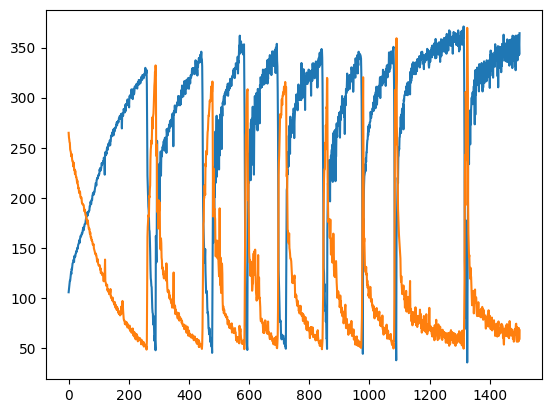

In [117]:
plt.plot(range(0,epoch_num+1), generator_history,discriminator_history)

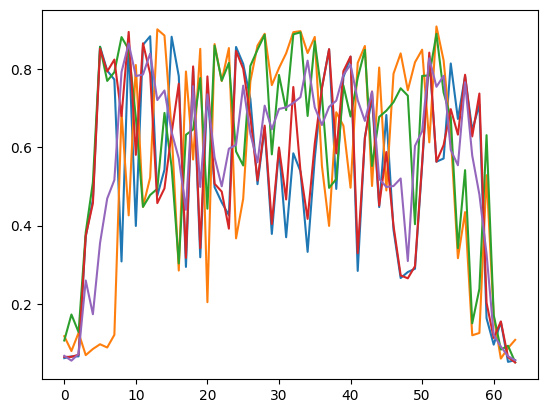

In [118]:
x=generate_noise()
y=generator(x).detach().numpy()
for i in range(5):
    plt.plot(y[i])

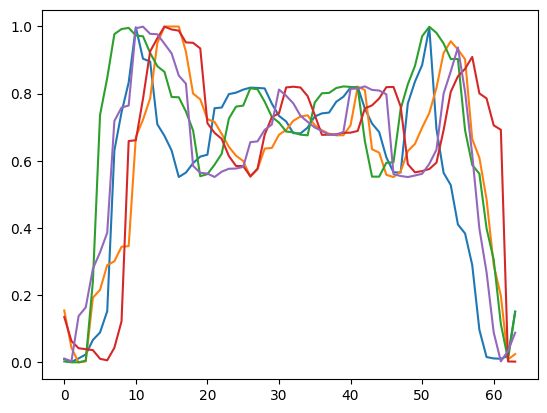

In [119]:
for i in range(5):
    plt.plot(Y[i])